In [1]:
import os
import pathlib

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from notebook_init_utils import bandicoot_check, init_notebook
from pycytominer import feature_select, normalize

root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [2]:
convolutions = list(range(1, 26))
convolutions += [50, 75, 100]
subdir_names = [f"convolution_{i}_image_based_profiles" for i in convolutions]
subdir_names += ["image_based_profiles"]
subdir_names += ["deconvolved_images_image_based_profiles"]

In [3]:
organoid_convolution_paths = [
    pathlib.Path(
        f"{image_base_dir}/data/NF0014_T1/{subdir_name}/2.annotated_profiles/organoid_anno.parquet"
    )
    for subdir_name in subdir_names
]

sc_convolution_paths = [
    pathlib.Path(
        f"{image_base_dir}/data/NF0014_T1/{subdir_name}/2.annotated_profiles/sc_anno.parquet"
    )
    for subdir_name in subdir_names
]

figure_dir = pathlib.Path(
    f"{root_dir}/7.technical_analysis/figures/convolution_profile_analysis"
).resolve()
figure_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Merge organoid profiles
organoid_combined_dfs = pd.concat(
    [
        pd.read_parquet(path).assign(
            Metadata_convolution=path.parent.parent.name.replace(
                "_image_based_profiles", ""
            )
        )
        for path in organoid_convolution_paths
    ],
    ignore_index=True,
)
organoid_combined_dfs["Metadata_convolution"] = organoid_combined_dfs[
    "Metadata_convolution"
].replace(
    {
        "image_based_profiles": "0",
        "deconvolved_images": "-1",
        "convolution_": "",
    },
    regex=True,
)
# drop all Metadata_image_sets that are not C4-2
organoid_combined_dfs = organoid_combined_dfs[
    organoid_combined_dfs["Metadata_image_set"] == "C4-2"
]
organoid_combined_dfs.reset_index(drop=True, inplace=True)
organoid_combined_dfs["Metadata_convolution"] = organoid_combined_dfs[
    "Metadata_convolution"
].astype(str)

# merge sc profiles
sc_combined_dfs = pd.concat(
    [
        pd.read_parquet(path).assign(
            Metadata_convolution=path.parent.parent.name.replace(
                "_image_based_profiles", ""
            )
        )
        for path in sc_convolution_paths
    ],
    ignore_index=True,
)
sc_combined_dfs["Metadata_convolution"] = sc_combined_dfs[
    "Metadata_convolution"
].replace(
    {
        "image_based_profiles": "0",
        "deconvolved_images": "-1",
        "convolution_": "",
    },
    regex=True,
)
# drop all Metadata_image_sets that are not C4-2
sc_combined_dfs = sc_combined_dfs[sc_combined_dfs["Metadata_image_set"] == "C4-2"]
sc_combined_dfs.reset_index(drop=True, inplace=True)
sc_combined_dfs["Metadata_convolution"] = sc_combined_dfs[
    "Metadata_convolution"
].astype(str)

In [5]:
organoid_metadata_columns = [
    x for x in organoid_combined_dfs.columns if "Metadata" in x
]

organoid_metadata_columns += [
    "Area.Size.Shape_Organoid_CENTER.X",
    "Area.Size.Shape_Organoid_CENTER.Y",
    "Area.Size.Shape_Organoid_CENTER.Z",
]
organoid_features_columns = [
    col for col in organoid_combined_dfs.columns if col not in organoid_metadata_columns
]

# sc metadata and features
sc_metadata_columns = [x for x in sc_combined_dfs.columns if "Metadata" in x]

sc_metadata_columns += [
    "Area.Size.Shape_Cell_CENTER.X",
    "Area.Size.Shape_Cell_CENTER.Y",
    "Area.Size.Shape_Cell_CENTER.Z",
    "Area.Size.Shape_Nuclei_CENTER.X",
    "Area.Size.Shape_Nuclei_CENTER.Y",
    "Area.Size.Shape_Nuclei_CENTER.Z",
    "Area.Size.Shape_Cytoplasm_CENTER.X",
    "Area.Size.Shape_Cytoplasm_CENTER.Y",
    "Area.Size.Shape_Cytoplasm_CENTER.Z",
]
sc_features_columns = [
    col for col in sc_combined_dfs.columns if col not in sc_metadata_columns
]

In [6]:
# normalize the data
organoid_normalized_profiles = normalize(
    organoid_combined_dfs,
    features=organoid_features_columns,
    meta_features=organoid_metadata_columns,
    method="standardize",
    samples="Metadata_convolution == '0'",
)
organoid_fs_df = feature_select(
    organoid_normalized_profiles,
    features=organoid_features_columns,
)

# normalize the data sc
sc_normalized_profiles = normalize(
    sc_combined_dfs,
    features=sc_features_columns,
    meta_features=sc_metadata_columns,
    method="standardize",
    samples="Metadata_convolution == '0'",
)
sc_fs_df = feature_select(
    sc_normalized_profiles,
    features=sc_features_columns,
)

/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [7]:
organoid_metadata_columns = [x for x in organoid_fs_df.columns if "Metadata" in x]

organoid_metadata_columns += [
    "Area.Size.Shape_Organoid_CENTER.X",
    "Area.Size.Shape_Organoid_CENTER.Y",
    "Area.Size.Shape_Organoid_CENTER.Z",
]
organoid_features_columns = [
    col for col in organoid_fs_df.columns if col not in organoid_metadata_columns
]

# sc metadata and features
sc_metadata_columns = [x for x in sc_fs_df.columns if "Metadata" in x]
sc_metadata_columns += [
    "Area.Size.Shape_Cell_CENTER.X",
    "Area.Size.Shape_Cell_CENTER.Y",
    "Area.Size.Shape_Cell_CENTER.Z",
    "Area.Size.Shape_Nuclei_CENTER.X",
    "Area.Size.Shape_Nuclei_CENTER.Y",
    "Area.Size.Shape_Nuclei_CENTER.Z",
    "Area.Size.Shape_Cytoplasm_CENTER.X",
    "Area.Size.Shape_Cytoplasm_CENTER.Y",
    "Area.Size.Shape_Cytoplasm_CENTER.Z",
]
sc_features_columns = [
    col for col in sc_fs_df.columns if col not in sc_metadata_columns
]

In [8]:
# save the normalized profiles
organoid_normalized_output_path = pathlib.Path(
    f"{root_dir}/7.technical_analysis/processed_data/organoid_fs_convolution_profiles.parquet"
).resolve()
sc_normalized_output_path = pathlib.Path(
    f"{root_dir}/7.technical_analysis/processed_data/sc_fs_convolution_profiles.parquet"
).resolve()
organoid_normalized_output_path.parent.mkdir(parents=True, exist_ok=True)
# replace na with 0
organoid_fs_df = organoid_fs_df.fillna(0)
organoid_fs_df.to_parquet(organoid_normalized_output_path, index=False)
sc_normalized_output_path.parent.mkdir(parents=True, exist_ok=True)
sc_fs_df = sc_fs_df.fillna(0)
sc_fs_df.to_parquet(sc_normalized_output_path, index=False)

/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


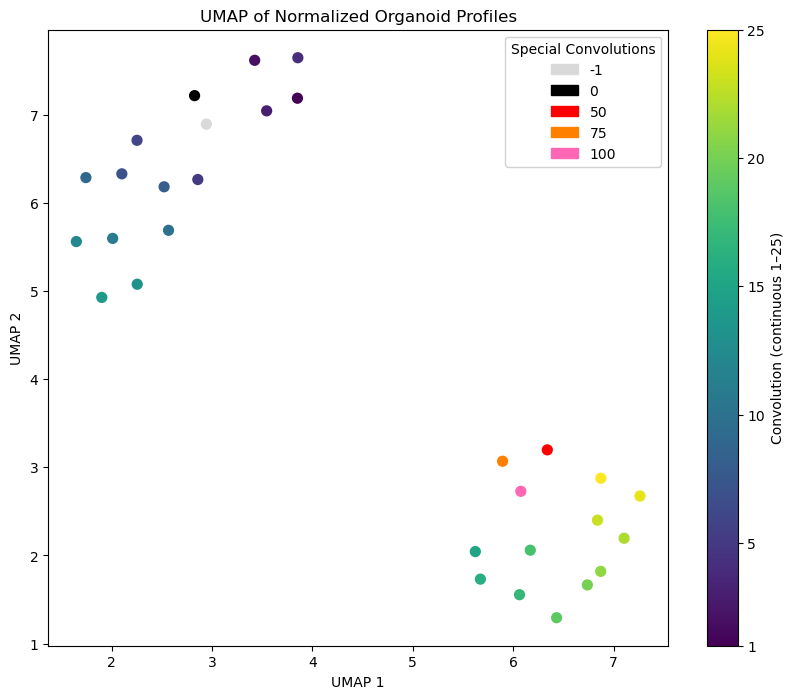

In [9]:
organoid_fs_df["Metadata_convolution"] = organoid_fs_df["Metadata_convolution"].astype(
    int
)
reducer = umap.UMAP(random_state=0)
embedding = reducer.fit_transform(organoid_fs_df[organoid_features_columns].values)

conv = organoid_fs_df["Metadata_convolution"].astype(int).values

cmap_cont = plt.cm.viridis
norm_cont = mpl.colors.Normalize(vmin=1, vmax=25)

special_colors = {
    # light gray
    -1: (0.85, 0.85, 0.85, 1.0),
    # black
    0: (0.0, 0.0, 0.0, 1.0),
    50: (1.0, 0.0, 0.0, 1.0),
    75: (1.0, 0.5, 0.0, 1.0),
    100: (1.0, 0.4, 0.7, 1.0),
}

colors = [
    special_colors[v]
    if v in special_colors
    else (cmap_cont(norm_cont(v)) if 1 <= v <= 25 else (0.85, 0.85, 0.85, 1.0))
    for v in conv
]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=colors,
    s=50,
    alpha=1.0,
    rasterized=True,
)

# create continuous colorbar for 1..25 and attach it to the axes
mappable = mpl.cm.ScalarMappable(norm=norm_cont, cmap=cmap_cont)
mappable.set_array(np.linspace(1, 25, 25))
cbar = fig.colorbar(mappable, ax=ax)
cbar.set_label("Convolution (continuous 1–25)")
cbar.set_ticks([1, 5, 10, 15, 20, 25])

# legend for special discrete values
legend_handles = [
    mpatches.Patch(color=special_colors[k], label=str(k)) for k in [-1, 0, 50, 75, 100]
]
# move legend outside of plot
ax.legend(
    handles=legend_handles,
    title="Special Convolutions",
    loc="upper right",
    framealpha=0.9,
)

ax.set_title("UMAP of Normalized Organoid Profiles")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
plt.savefig(figure_dir / "organoid_convolution_umap.png", dpi=600, bbox_inches="tight")
plt.show()

/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


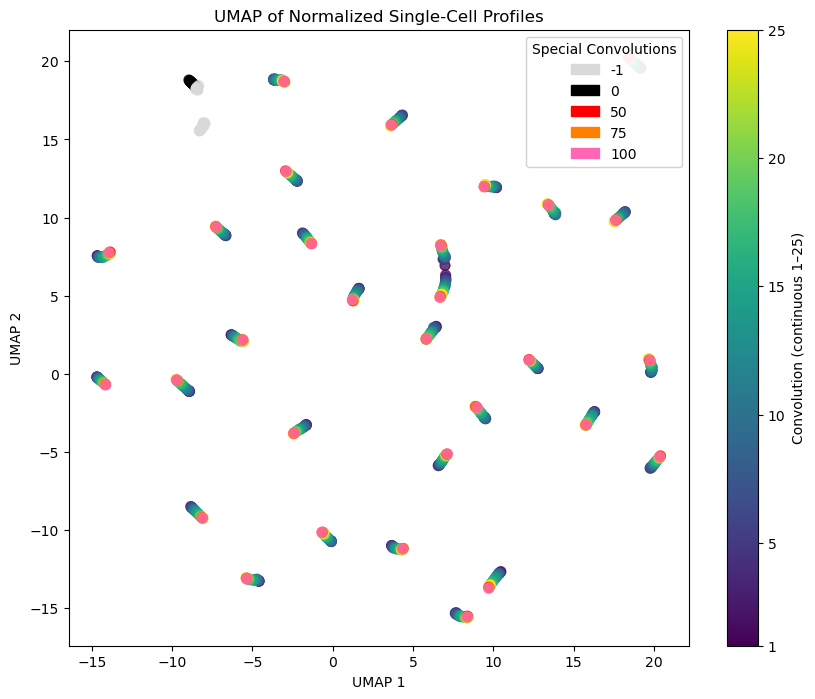

In [10]:
sc_fs_df["Metadata_convolution"] = sc_fs_df["Metadata_convolution"].astype(int)
reducer = umap.UMAP(random_state=0)
embedding = reducer.fit_transform(sc_fs_df[sc_features_columns].values)

conv = sc_fs_df["Metadata_convolution"].astype(int).values

cmap_cont = plt.cm.viridis
norm_cont = mpl.colors.Normalize(vmin=1, vmax=25)

special_colors = {
    # light gray
    -1: (0.85, 0.85, 0.85, 1.0),
    # black
    0: (0.0, 0.0, 0.0, 1.0),
    50: (1.0, 0.0, 0.0, 1.0),
    75: (1.0, 0.5, 0.0, 1.0),
    100: (1.0, 0.4, 0.7, 1.0),
}

colors = [
    special_colors[v]
    if v in special_colors
    else (cmap_cont(norm_cont(v)) if 1 <= v <= 25 else (0.85, 0.85, 0.85, 1.0))
    for v in conv
]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=colors,
    s=50,
    alpha=0.75,
    rasterized=True,
)

# create continuous colorbar for 1..25 and attach it to the axes
mappable = mpl.cm.ScalarMappable(norm=norm_cont, cmap=cmap_cont)
mappable.set_array(np.linspace(1, 25, 25))
cbar = fig.colorbar(mappable, ax=ax)
cbar.set_label("Convolution (continuous 1–25)")
cbar.set_ticks([1, 5, 10, 15, 20, 25])

# legend for special discrete values
legend_handles = [
    mpatches.Patch(color=special_colors[k], label=str(k)) for k in [-1, 0, 50, 75, 100]
]
# move legend outside of plot
ax.legend(
    handles=legend_handles,
    title="Special Convolutions",
    loc="upper right",
    framealpha=0.9,
)

ax.set_title("UMAP of Normalized Single-Cell Profiles")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
plt.savefig(figure_dir / "sc_convolution_umap.png", dpi=600, bbox_inches="tight")
plt.show()